In [45]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Results from All Providers

In [46]:
def load_latest_results(provider):
    """Load the most recent comparison results for a provider."""
    # Map display names to directory names
    provider_map = {
        'GPT-5.2': 'openai',
        'Claude 4.5 Sonnet': 'claude',
        'LLama-4 Maverick 17B': 'groq',
        'Deepseek-chat': 'deepseek'
    }
    
    dir_name = provider_map.get(provider, provider.lower())
    reports_dir = Path(f'reports_{dir_name}')
    
    if not reports_dir.exists():
        return None
    
    # Find most recent JSON file
    json_files = list(reports_dir.glob('comparison_details_*.json'))
    if not json_files:
        return None
    
    latest = max(json_files, key=lambda p: p.stat().st_mtime)
    
    with open(latest, 'r') as f:
        return json.load(f)

def calculate_metrics(data):
    """Calculate key metrics from comparison data.
    
    IMPORTANT: Scores are based only on files that originally compiled (41 files).
    We can't fairly judge refactoring quality on files that don't compile in the first place.
    """
    if not data:
        return None
    
    total = len(data)
    original_compiled = sum(1 for d in data if d['original_compilation']['compiled'])
    refactored_compiled = sum(1 for d in data if d['refactored_compilation']['compiled'])
    both_compiled = sum(1 for d in data if d['original_compilation']['compiled'] and d['refactored_compilation']['compiled'])
    outputs_match = sum(1 for d in data if d.get('outputs_match') is True)
    
    # KEY CHANGE: Base percentages on original_compiled (41 files), not total (76 files)
    refactored_success_pct = both_compiled / original_compiled * 100 if original_compiled > 0 else 0
    match_pct = outputs_match / both_compiled * 100 if both_compiled > 0 else 0
    
    return {
        'total': total,
        'original_compiled': original_compiled,
        'refactored_compiled': refactored_compiled,
        'both_compiled': both_compiled,
        'outputs_match': outputs_match,
        'original_pct': original_compiled / total * 100,
        # New metrics based on original_compiled baseline
        'refactored_success_pct': refactored_success_pct,  # Of originals that compiled, how many refactored also compiled
        'match_pct': match_pct,  # Of files that both compiled, how many matched output
        # Old metrics for reference
        'refactored_pct_old': refactored_compiled / total * 100,
    }

# Load results for all providers
providers = ['GPT-5.2', 'Claude 4.5 Sonnet', 'LLama-4 Maverick 17B', 'Deepseek-chat']
results = {}

for provider in providers:
    data = load_latest_results(provider)
    metrics = calculate_metrics(data)
    if metrics:
        results[provider] = metrics
        print(f"✓ Loaded {provider}: {metrics['both_compiled']}/{metrics['original_compiled']} successful refactorings")
    else:
        # Use placeholder data if results not available yet
        print(f"⚠ No results for {provider} - using placeholder data")
        results[provider] = {
            'total': 76,
            'original_compiled': 41,
            'refactored_compiled': 0,
            'both_compiled': 0,
            'outputs_match': 0,
            'original_pct': 53.9,
            'refactored_success_pct': 0,
            'match_pct': 0,
            'refactored_pct_old': 0
        }

✓ Loaded GPT-5.2: 33/41 successful refactorings
✓ Loaded Claude 4.5 Sonnet: 32/41 successful refactorings
✓ Loaded LLama-4 Maverick 17B: 23/40 successful refactorings
✓ Loaded Deepseek-chat: 31/41 successful refactorings


## Summary Table

In [47]:
# Create summary dataframe
df = pd.DataFrame(results).T
df_display = df[['original_compiled', 'both_compiled', 'outputs_match']].copy()
df_display.columns = ['Original Compiled (Baseline)', 'Refactored Successfully', 'Outputs Match']

print("\n" + "="*80)
print("COMPILATION RESULTS BY PROVIDER (Based on 41 files that originally compiled)")
print("="*80)
print(df_display.to_string())
print("\n")

# Percentage table
df_pct = df[['refactored_success_pct', 'match_pct']].copy()
df_pct.columns = ['Refactored Success Rate %', 'Output Match Rate %']
print("\nSUCCESS RATES:")
print("(Refactored Success = Of 41 originals that compiled, how many refactored versions also compiled)")
print("(Output Match = Of files where both compiled, how many produced identical output)")
print(df_pct.round(1).to_string())


COMPILATION RESULTS BY PROVIDER (Based on 41 files that originally compiled)
                      Original Compiled (Baseline)  Refactored Successfully  Outputs Match
GPT-5.2                                       41.0                     33.0           13.0
Claude 4.5 Sonnet                             41.0                     32.0           14.0
LLama-4 Maverick 17B                          40.0                     23.0            7.0
Deepseek-chat                                 41.0                     31.0           11.0



SUCCESS RATES:
(Refactored Success = Of 41 originals that compiled, how many refactored versions also compiled)
(Output Match = Of files where both compiled, how many produced identical output)
                      Refactored Success Rate %  Output Match Rate %
GPT-5.2                                    80.5                 39.4
Claude 4.5 Sonnet                          78.0                 43.8
LLama-4 Maverick 17B                       57.5                

## Visualization 1: Compilation Success Rates

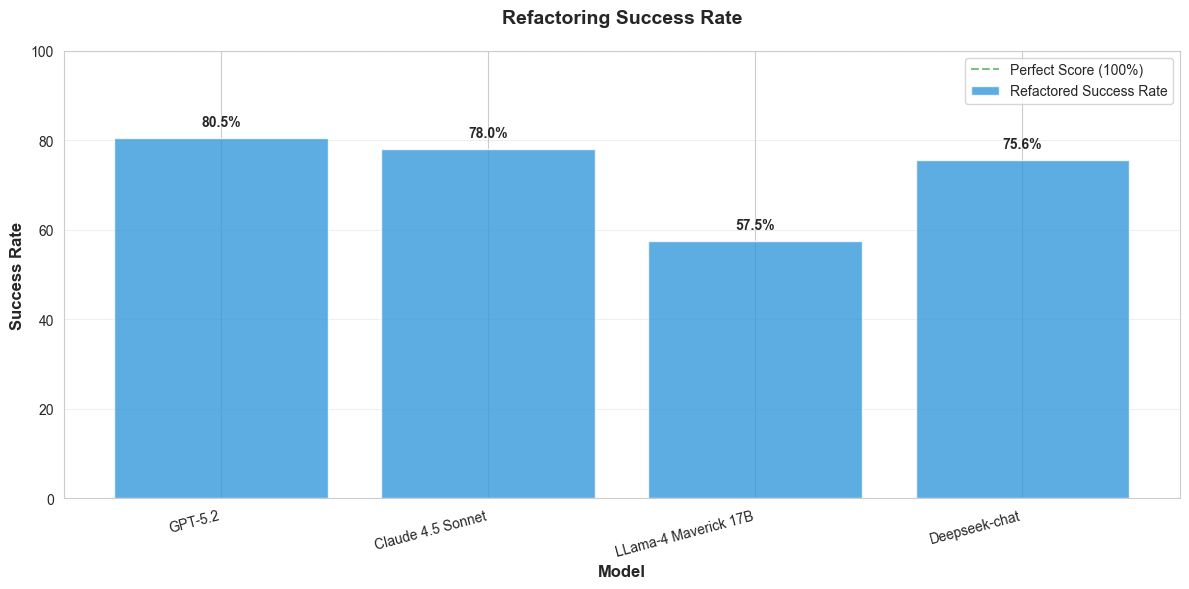

In [55]:
fig, ax = plt.subplots(figsize=(12, 6))

providers_list = list(results.keys())
x = range(len(providers_list))
width = 0.8

refactored_success = [results[p]['refactored_success_pct'] for p in providers_list]

bars = ax.bar(x, refactored_success, width, label='Refactored Success Rate', color='#3498db', alpha=0.8)

ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Success Rate', fontsize=12, fontweight='bold')
ax.set_title('Refactoring Success Rate', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(providers_list, rotation=15, ha='right')
ax.set_ylim(0, 100)
ax.grid(axis='y', alpha=0.3)

# Add baseline reference line
ax.axhline(y=100, color='green', linestyle='--', alpha=0.5, label='Perfect Score (100%)')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax.text(bar.get_x() + bar.get_width()/2., height + 2,
               f'{height:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.legend()
plt.tight_layout()
plt.show()

## Visualization 2: Output Correctness Rate

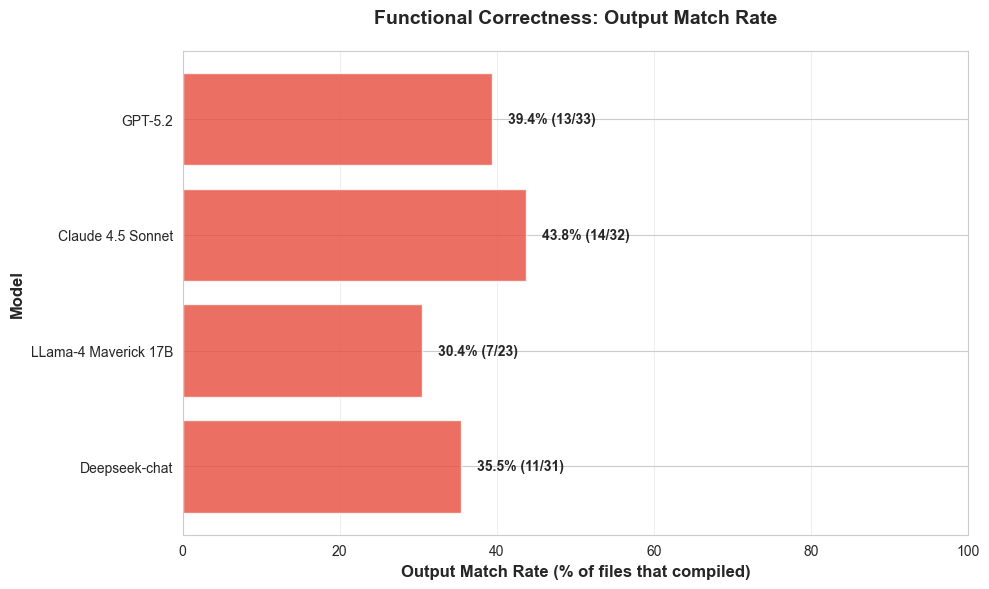

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))

match_rates = [results[p]['match_pct'] for p in providers_list]
colors = ['#2ecc71' if rate > 70 else '#f39c12' if rate > 50 else '#e74c3c' for rate in match_rates]

bars = ax.barh(providers_list, match_rates, color=colors, alpha=0.8)

ax.set_xlabel('Output Match Rate (% of files that compiled)', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Functional Correctness: Output Match Rate', fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)

# Reverse y-axis to show best at top
ax.invert_yaxis()

# Add value labels
for i, (bar, rate) in enumerate(zip(bars, match_rates)):
    if rate > 0:
        both = results[providers_list[i]]['both_compiled']
        matched = results[providers_list[i]]['outputs_match']
        ax.text(rate + 2, bar.get_y() + bar.get_height()/2,
               f'{rate:.1f}% ({matched}/{both})',
               va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Visualization 3: Success Pipeline (Stacked Bar Chart)

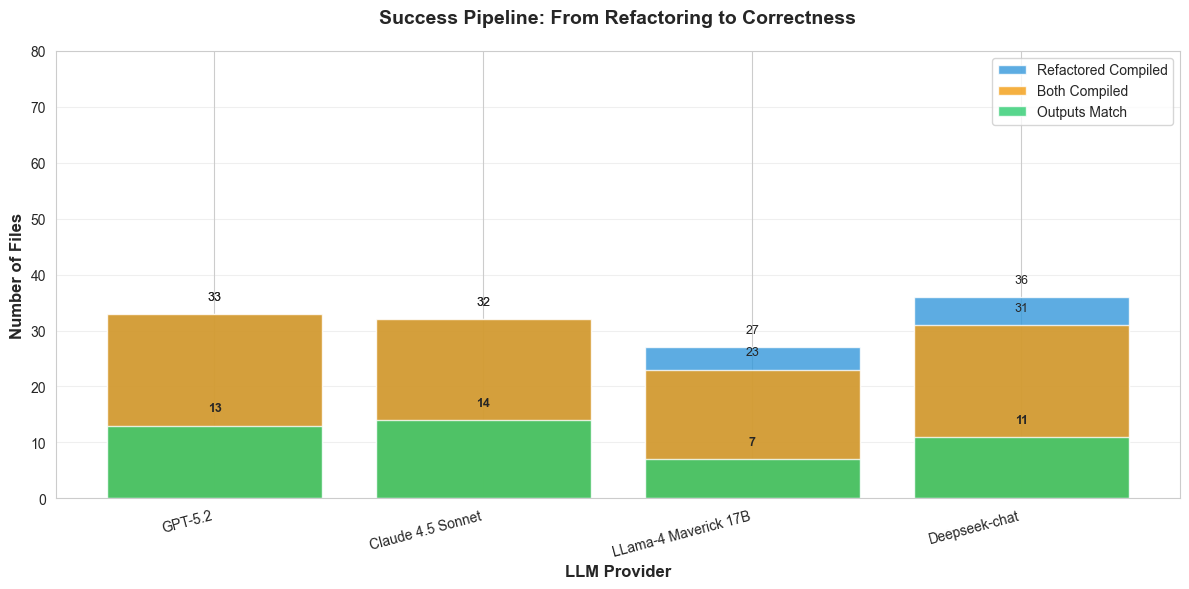

In [50]:
fig, ax = plt.subplots(figsize=(12, 6))

# Calculate stages
compiled = [results[p]['refactored_compiled'] for p in providers_list]
both = [results[p]['both_compiled'] for p in providers_list]
matched = [results[p]['outputs_match'] for p in providers_list]

# Stacked bars showing the pipeline
x = range(len(providers_list))

bars1 = ax.bar(x, compiled, label='Refactored Compiled', color='#3498db', alpha=0.8)
bars2 = ax.bar(x, both, label='Both Compiled', color='#f39c12', alpha=0.8)
bars3 = ax.bar(x, matched, label='Outputs Match', color='#2ecc71', alpha=0.8)

ax.set_xlabel('LLM Provider', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
ax.set_title('Success Pipeline: From Refactoring to Correctness', fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(providers_list, rotation=15, ha='right')
ax.legend()
ax.set_ylim(0, 80)
ax.grid(axis='y', alpha=0.3)

# Add value labels
for i, p in enumerate(providers_list):
    ax.text(i, compiled[i] + 2, str(compiled[i]), ha='center', va='bottom', fontsize=9)
    ax.text(i, both[i] + 2, str(both[i]), ha='center', va='bottom', fontsize=9)
    ax.text(i, matched[i] + 2, str(matched[i]), ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## Visualization 4: Overall Score (Weighted)

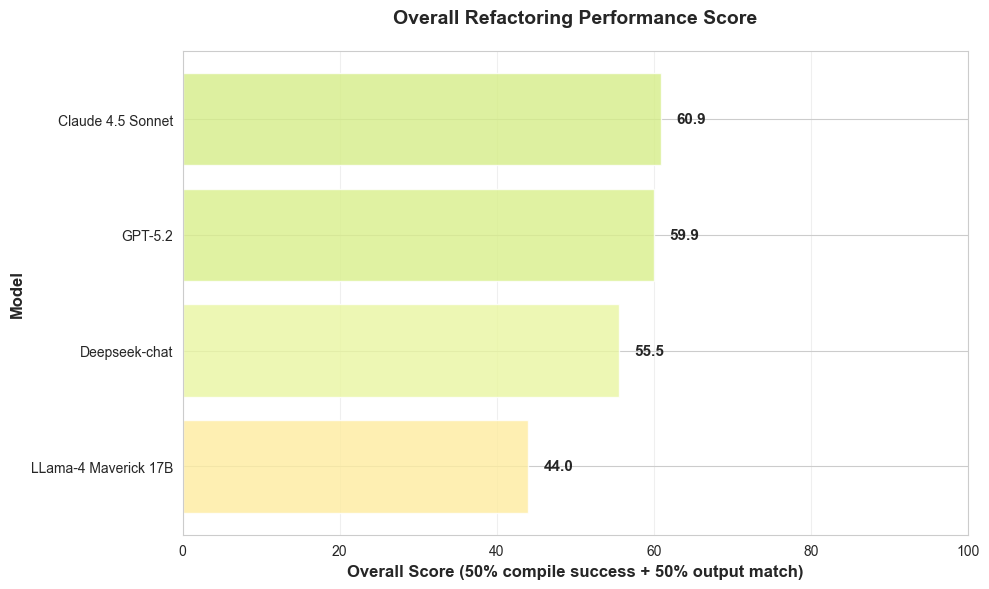


FINAL RANKINGS (Based on 41 files that originally compiled)
1. Claude 4.5 Sonnet: 60.9 points
   ├─ Refactored success: 78.0% (32/41)
   └─ Output match: 43.8% (14/32)

2. GPT-5.2: 59.9 points
   ├─ Refactored success: 80.5% (33/41)
   └─ Output match: 39.4% (13/33)

3. Deepseek-chat: 55.5 points
   ├─ Refactored success: 75.6% (31/41)
   └─ Output match: 35.5% (11/31)

4. LLama-4 Maverick 17B: 44.0 points
   ├─ Refactored success: 57.5% (23/41)
   └─ Output match: 30.4% (7/23)



In [57]:
# Calculate weighted score:
# 50% weight on refactored success rate (of 41 originals, how many refactored compiled)
# 50% weight on output match rate (of those that compiled, how many matched)

scores = {}
for p in providers_list:
    compile_score = results[p]['refactored_success_pct']
    match_score = results[p]['match_pct']
    overall = (compile_score * 0.5 + match_score * 0.5)
    scores[p] = overall

# Sort by score
sorted_providers = sorted(scores.items(), key=lambda x: x[1], reverse=True)

fig, ax = plt.subplots(figsize=(10, 6))

names = [p[0] for p in sorted_providers]
values = [p[1] for p in sorted_providers]
colors = plt.cm.RdYlGn([v/100 for v in values])

bars = ax.barh(names, values, color=colors, alpha=0.8)

ax.set_xlabel('Overall Score (50% compile success + 50% output match)', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Overall Refactoring Performance Score', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 100)
ax.grid(axis='x', alpha=0.3)
ax.invert_yaxis()

# Add value labels
for bar, value in zip(bars, values):
    if value > 0:
        ax.text(value + 2, bar.get_y() + bar.get_height()/2,
               f'{value:.1f}',
               va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("FINAL RANKINGS (Based on 41 files that originally compiled)")
print("="*80)
for i, (provider, score) in enumerate(sorted_providers, 1):
    compile_pct = results[provider]['refactored_success_pct']
    match_pct = results[provider]['match_pct']
    print(f"{i}. {provider}: {score:.1f} points")
    print(f"   ├─ Refactored success: {compile_pct:.1f}% ({results[provider]['both_compiled']}/41)")
    print(f"   └─ Output match: {match_pct:.1f}% ({results[provider]['outputs_match']}/{results[provider]['both_compiled']})")
    print()

## Export Results

In [52]:
# Save summary to CSV
df_export = pd.DataFrame(results).T
df_export.to_csv('experiment_results_summary.csv')
print("✓ Results exported to experiment_results_summary.csv")

✓ Results exported to experiment_results_summary.csv
